<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `data.csv`. Количество заказов находится в столбце `num_orders` 

## Подготовка

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

In [2]:
try:
    data = pd.read_csv("data.csv", index_col=[0], parse_dates=[0])
except:
    print('could not open the file')

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Всего два столбца - время и количество заказов

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет. Период охватывает март-август 18г.

In [5]:
data.index.is_monotonic

True

Данные хронологически упорядочены

In [6]:
period = data.index.max() - data.index.min()
period

Timedelta('183 days 23:50:00')

In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество заказов в час колеблется от 0 до 119

**При подготовке данных пропусков обнаружено не было. Данные упорядочены хронологически, период наблюдений охватывает 183 дня 23 часа.**

## Анализ

Сделаем ресемплинг по часам и по дням

<AxesSubplot:xlabel='datetime'>

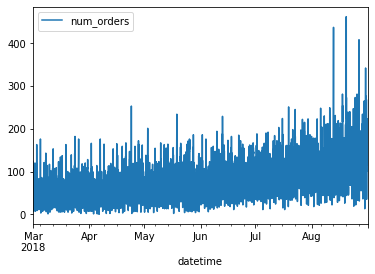

In [8]:
data = data.resample('1H').sum()
data.plot()

<AxesSubplot:xlabel='datetime'>

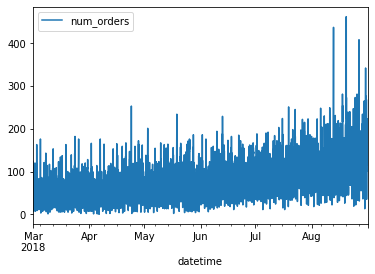

In [9]:
data_day = data.copy()
data_day = data_day.resample('1D').sum()
data.plot()

Используем метод сглаживания, выбрав размер окна, равный 25 дням.

<AxesSubplot:xlabel='datetime'>

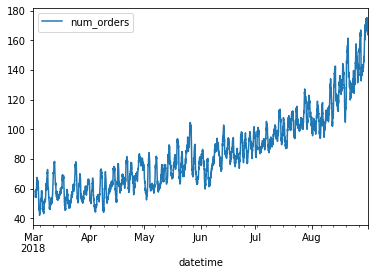

In [10]:
data.rolling(25).mean().plot()

На графике явно видна тенденция роста заказов с каждым месяцем, особенно ярко выраженная за июль и август.

Разложим временной ряд на тренд сезонность и остаток

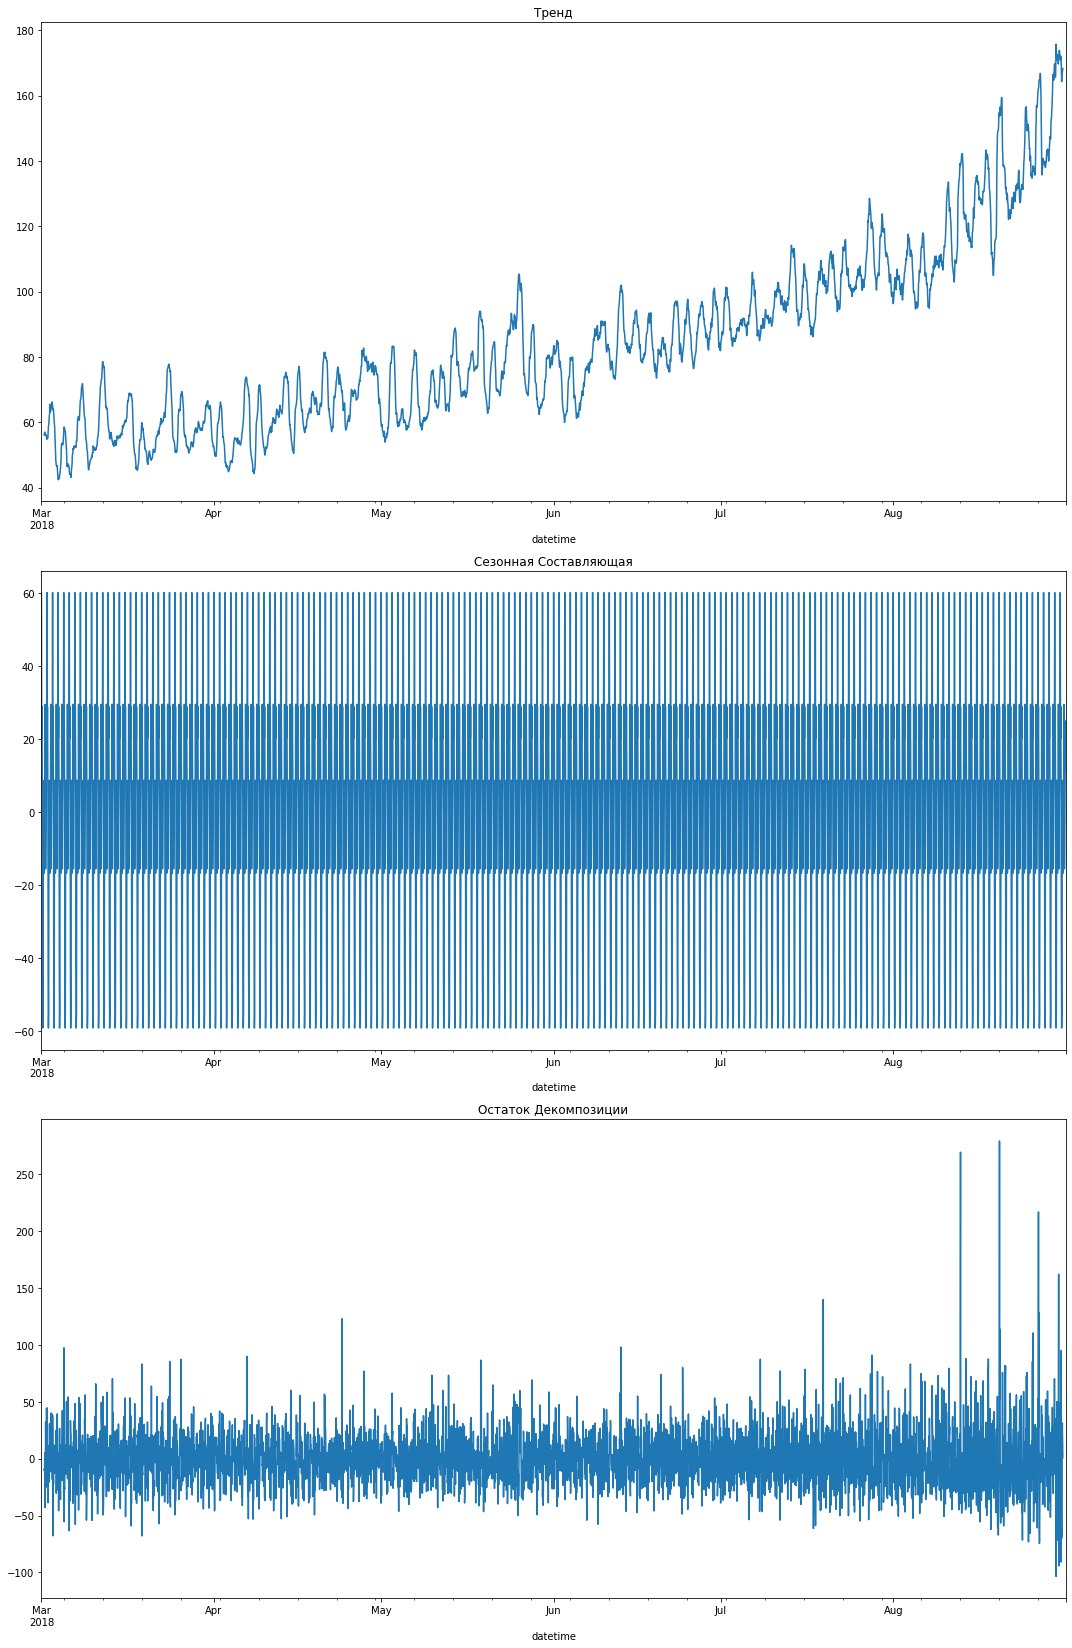

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15,23))


#тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title("Тренд")

#сезонная составляющая
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Сезонная Составляющая")

#остаток декомпозиции
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток Декомпозиции')

plt.tight_layout()

На графике "Тренд" наблюдаем динамику увеличения количества вызовов за предоставленный период времени. Это может быть связано с ростом популярности начинающей компании, которая ещё не вышла на пик своих возможностей. Также рост можно объяснить увеличением количества пассажиров самолётов в тёплое время года. Отследить сезонность, связанную со сменой времен года невозможно, поскольку предоставленный промежуток времени не даёт такой возможности. Сезонность может быть связана с днём недели, попробуем проверить.

Text(0.5, 1.0, 'Сезонная Составляющая')

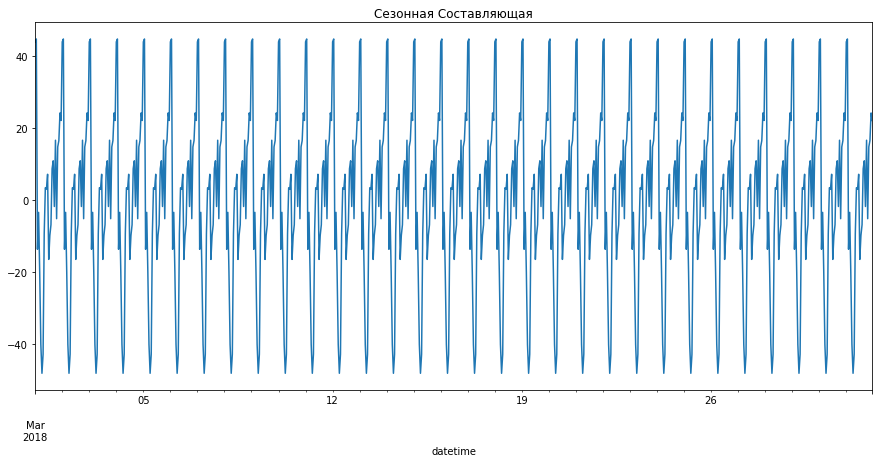

In [12]:
data1 = data['2018-01':'2018-03']
decomposed = seasonal_decompose(data1)
plt.figure(figsize=(15,23))

#сезонная составляющая
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Сезонная Составляющая")

Судя по тому, что периодичность составляет 7дней, похоже, мы правы.

Чтобы отследить суточную периодичность, построим графики на несколько дней

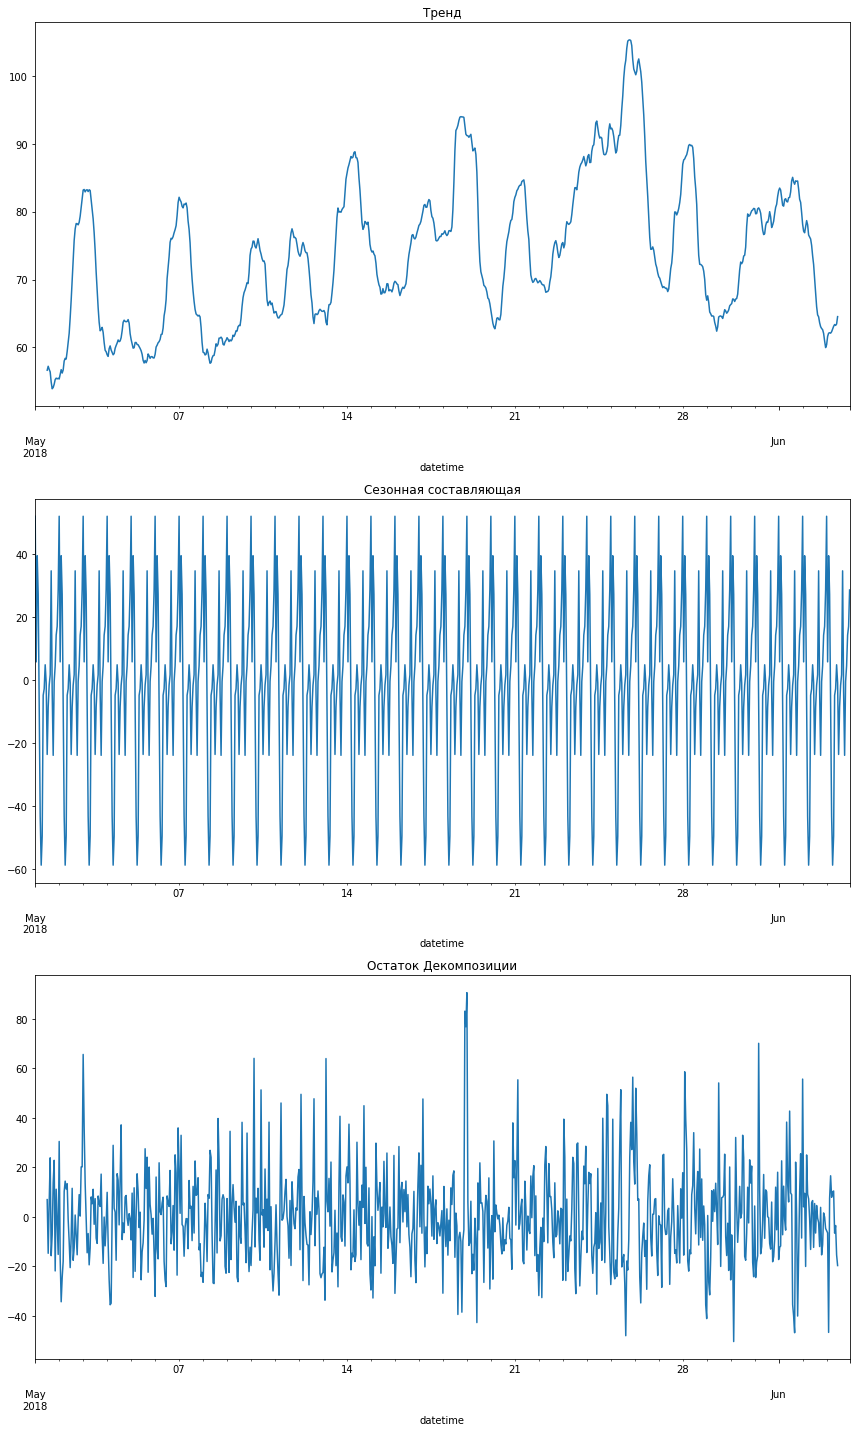

In [13]:
data_hour = data.copy()
data_hour = data_hour.resample('1H').sum()
decomposed = seasonal_decompose(data_hour['2018-05-01 00:00:00':'2018-06-03 23:50:00'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток Декомпозиции')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

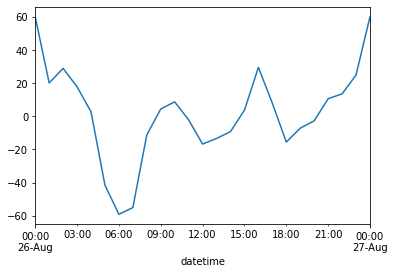

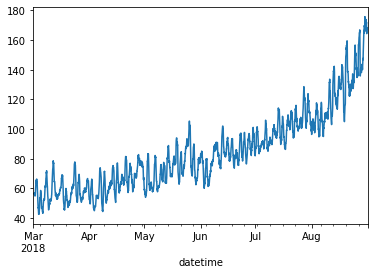

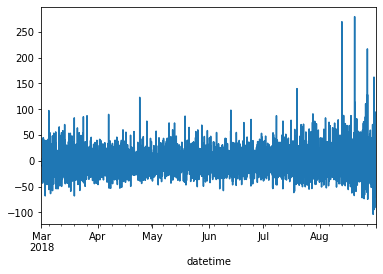

<Figure size 432x288 with 0 Axes>

In [14]:
seasonal_decompose(data_hour).seasonal.plot()
plt.xlim('2018-08-26', '2018-08-27')
plt.figure()
seasonal_decompose(data_hour).trend.plot(ax=plt.gca())
plt.figure()
seasonal_decompose(data_hour).resid.plot(ax=plt.gca())
plt.figure()

На графике сезонной составляющей отчетливо видна зависимость количества заказов от времени суток. Наблюдаем резкое падение спроса с 3 до 6 часов, резкий подъём с выходом на локальный максимум в 9, ещё один максимум появляется в 16. Локальные максимумы логично связать с увеличением количества приземлившихся самолётов. Основной максимум приходится на 24. Такой спрос может быть обусловлен, кроме прочего, отсутствием другого общественного транспорта в это время суток.

**Анализ данных показал динамику роста заказов на данном промежутке времени. Прослеживается периодичность частоты заказов, связанная с днём недели и временем суток.**

## Обучение

Обучим разные модели с различными гиперпараметрами. Создадим признаки, используя для этого "отстающие значения" и скользящее среднее. Понадобится функция.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

Для функции используем следующие аргументы: max_lag=24 часа, rolling_mean_size=25

In [16]:
make_features(data, 24, 25)
data

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,165.36
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.72
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,167.00


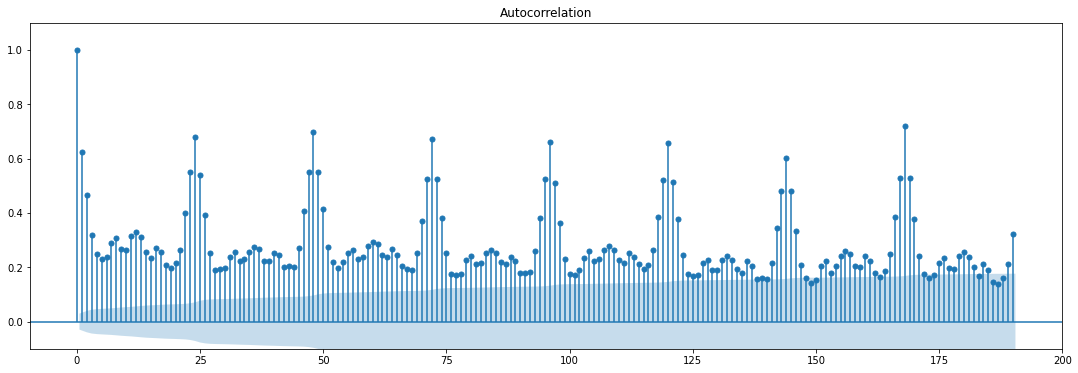

In [17]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


 Удалим строки с образовавшимися пропусками

In [18]:
data = data.dropna()
data

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,58.16
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,58.00
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.60
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,57.32
2018-03-02 05:00:00,11,2,4,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,55.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,165.36
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.72
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,167.00


 Разделим данные на тестовые и обучающие. Сделаем тестовую выборку размером 10% от исходных данных. Добавим shuffle=False, чтобы данные не перемешались.

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Выделим целевой признак 

In [20]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

### Линейная регрессия

In [21]:
cv = TimeSeriesSplit(n_splits=5)

In [22]:

model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
scores_reg = cross_val_score(model_reg, features_train, target_train, cv=cv, scoring='neg_root_mean_squared_error').mean()*(-1)
print("ошибка для линейной регрессии", scores_reg)

ошибка для линейной регрессии 27.23469281376549


### Случайный лес

In [23]:
parameters = {'n_estimators':(10, 80, 10),
    'max_depth':(1, 51, 10), 'min_samples_leaf':(1,12)}
model_ran_for = RandomForestRegressor()
clf_forest = GridSearchCV(model_ran_for, parameters, cv=cv, scoring='neg_root_mean_squared_error')
clf_forest.fit(features_train, target_train )

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': (1, 51, 10), 'min_samples_leaf': (1, 12),
                         'n_estimators': (10, 80, 10)},
             scoring='neg_root_mean_squared_error')

In [24]:
print("Лучшие параметры для случайного леса:")
clf_forest.best_params_

Лучшие параметры для случайного леса:


{'max_depth': 51, 'min_samples_leaf': 1, 'n_estimators': 80}

In [25]:
print("ошибка для случайного леса:", clf_forest.best_score_*(-1))

ошибка для случайного леса: 25.79086312955497


### LightGBM

In [26]:
param_lgbm = {'num_leaves':(15, 5, 10), 'n_estimators': (100, 150)}
mod_l_g_b_m = LGBMRegressor()

clf = GridSearchCV(mod_l_g_b_m, param_lgbm, cv=cv, scoring='neg_root_mean_squared_error')
clf.fit(features_train, target_train )

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'n_estimators': (100, 150), 'num_leaves': (15, 5, 10)},
             scoring='neg_root_mean_squared_error')

In [27]:
print("лучшие параметры для бустинга:")
clf.best_params_

лучшие параметры для бустинга:


{'n_estimators': 100, 'num_leaves': 10}

In [28]:
print("ошибка для бустинга:", mean_squared_error(clf.best_estimator_.predict(features_train), target_train)**0.5)

ошибка для бустинга: 19.0233981911129


 **На тренировочных данных были обучены три модели: LightGBM, LinearRegression, RandomForestRegressor. Гиперепараметры и качество для моделей подбирались с помощью кросс-валидации TimeSeriesSplit.   
 ошибка для линейной регрессии: 27.24  
 ошибка для случайного леса: 26.03   
 ошибка для бустинга: 19.02**
 

## Тестирование

Протестируем на всех обученных моделях.

In [29]:
reg_train_pred = model_reg.predict(features_test)
print("ошибка для регрессии при тестировании составила:", mean_squared_error(target_test, reg_train_pred)**0.5)

ошибка для регрессии при тестировании составила: 45.07380022921502


In [30]:
print("ошибка для случайного леса при тестировании составила:")
mean_squared_error(clf_forest.best_estimator_.predict(features_test), target_test)**0.5

ошибка для случайного леса при тестировании составила:


43.9397914546984

In [31]:
print("ошибка для бустинга:", mean_squared_error(clf.best_estimator_.predict(features_test), target_test)**0.5)

ошибка для бустинга: 42.87282209442781


**Тестирование на всех обученных моделях показало следующие результаты:
Ошибка для регрессии 45.07  
ошибка для случайного леса 44.20   
ошибка для бустинга 42.87   
Самые лучшие результаты показала модель LightGBM.**

##  Вывод:

**Предоставленные данные были проверены на монотонность индекса и наличие пропусков. Анализ данных показал тренд роста количества вызов в час. Такая динамика может быть связана с хорошим развитием компании, а также с тем, что в тёплые месяцы люди охотнее летают. Также была отмечена суточная сезонность с падением спроса с 3 до 6 часов и с локальными максимумами в 9 и 16 часов. Скорее всего эта сезонность связана с популярностью рейсов, которые пребывают или отправляются в это время. Люди не очень любят ночные рейсы. Глобальный максимум в 24, кроме ранее озвученной причины, вероятно связан с отсутсвием другого общественного транспорта в это время. Также прослеживается периодичность частоты заказов, связанная с днём недели.   
Для обучения моделей были добавлены признаки час и день недели, а также "скользящее среднее" и "отстающие значения", строки с пропусками были удалены.    
На тренировочных данных были обучены три модели: LightGBM, LinearRegression, RandomForestRegressor. Гиперепараметры и качество для моделей подбирались с помощью кросс-валидации TimeSeriesSplit.   
Ошибка для линейной регрессии: 27.24   
ошибка для случайного леса: 26.03   
ошибка для бустинга: 19.02     
 Тестирование всех обученных моделей показало следующие результаты:    
 Ошибка для регрессии 45.07     
ошибка для случайного леса 44.20      
ошибка для бустинга 42.87          
Все модели показали допустимые результаты, лучший результат показала модель LightGBM**